In [15]:
from preprocess import pre_process
from classify import classify
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from tqdm import tqdm
import cv2
import pytesseract
import numpy as np

In [3]:
"""
pre_process(
    "data/images/league/jankos",
    "jankos/boxes",
    conf_threshold=70,
    should_binarize=True,
    binarize_threshold=100,
    save_as_new_imgs=True
)
"""

'\npre_process(\n    "data/images/league/jankos",\n    "jankos/boxes",\n    conf_threshold=70,\n    should_binarize=True,\n    binarize_threshold=100,\n    save_as_new_imgs=True\n)\n'

100%|██████████| 2677/2677 [00:15<00:00, 176.04it/s]
/Users/mork/anaconda3/envs/kino/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mork/anaconda3/envs/kino/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 2677/2677 [02:27<00:00, 18.11it/s]


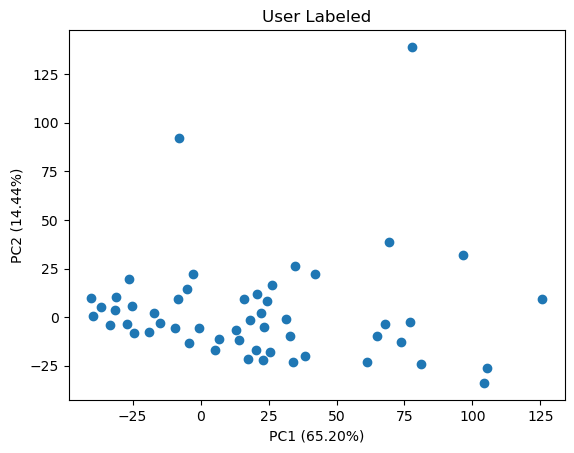

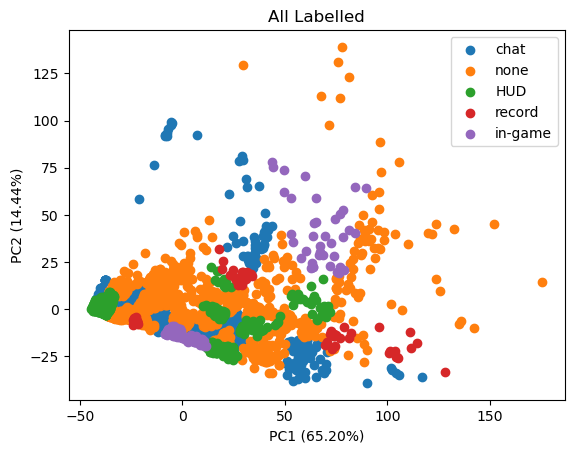

'\n'

In [6]:
classifier, labeller = classify("jankos/boxes")
"""
"""

In [9]:
class OutputManager:
    def __init__(self, labels: list[str], output_dir="output", num_remember = 15):
        self.labels = labels
        # Remember the last things we've written to avoid adding to log
        # multiple times from consecutive frames
        self.num_remember = num_remember
        self.memory: dict[str, list[str]] = {lbl:[] for lbl in labels}
        self.output_dir = output_dir
        self.fds = {}
        for label in labels:
            self.fds[label] = open(f"{output_dir}/{label}.json", "w")
            self.fds[label].write('{\n\t"texts": [\n')
    
    def close(self):
        for fd in self.fds.values():
            fd.write("\n\t]\n}\n")
            fd.close()
    
    @staticmethod
    def pretty_timestamp(timestamp):
        seconds = int(int(timestamp) / 1000)
        minutes = int(seconds / 60) % 60
        hours = int(seconds / 3600)
        seconds = seconds % 60
        return f"{hours:02d}:{minutes:02d}:{seconds:02d}"
    
    def add_text(self, label, timestamp, text):
        # Remove " and \ from text so JSON doesn't get messed up
        text = text.replace('"', "''").replace("\\", "")
        if text in self.memory[label]:
            return
        if len(self.memory[label]) > 0:
            self.fds[label].write(",\n")
        self.memory[label].append(text)
        while len(self.memory[label]) > self.num_remember:
            self.memory[label].pop(0)
        self.fds[label].write(
            f'\t\t["{OutputManager.pretty_timestamp(timestamp)}", "{text}"]'
        )

In [68]:
class TrOCRProcessDataset(Dataset):
    """
    Loads data from pre-processing and classifying in a performant
    format for final text identification using TrOCR
    """
    def __init__(self, labeller, classifier, processor, color_dir: str):
        self.labeller = labeller
        self.classifier = classifier
        self.processor = processor
        self.color_dir = color_dir
        self.frames_in_order = sorted(classifier.key2ix.keys(), key=lambda x: int(x.split("_")[0]))
    
    def __len__(self):
        return len(self.classifier.key2ix)
    
    def __getitem__(self, ix):
        key = self.frames_in_order[ix]
        timestamp = key.split("_")[0]
        label = self.labeller.ix2label[self.classifier.key2ix[key]]
        filepath = f"{self.color_dir}/{key}.jpg"
        img = Image.open(filepath).convert("RGB")
        pixel_values = self.processor(img, return_tensors="pt").pixel_values
        return {
            "pixel_values": pixel_values.squeeze(),
            "label": label,
            "key": key,
            "timestamp": timestamp
        }

In [69]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
process_ds = TrOCRProcessDataset(labeller, classifier, processor, "jankos/boxes/color")
process_loader = DataLoader(process_ds, batch_size=8, shuffle=False)
labels = list(labeller.label2ixs.keys())
out_man = OutputManager(labels)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [70]:
# Force CPU for users without fancy GPUs
device = torch.device("cpu")

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
model.to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [71]:
for batch in tqdm(process_loader):
    # predict using generate
    pixel_values = batch["pixel_values"].to(device)
    outputs = model.generate(pixel_values, max_new_tokens=1000)
    pred_str = process_ds.processor.batch_decode(outputs, skip_special_tokens=False, max_new_tokens=1000)
    for ix, label in enumerate(batch["label"]):
        out_man.add_text(label, batch["timestamp"][ix], pred_str[ix])

  1%|          | 3/332 [00:44<1:22:13, 15.00s/it]


KeyboardInterrupt: 

In [10]:
class TesseractProcessDataset(Dataset):
    """
    Loads data from pre-processing and classifying in a performant
    format for final text identification using tesseract
    NOTE: Needed because even with optimization, I could not get
    TrOCR to run fast enough when device=CPU. Very similar to dataset above
    """
    def __init__(self, labeller, classifier, color_dir: str):
        self.labeller = labeller
        self.classifier = classifier
        self.color_dir = color_dir
        self.frames_in_order = sorted(classifier.key2ix.keys(), key=lambda x: int(x.split("_")[0]))
    
    def __len__(self):
        return len(self.classifier.key2ix)
    
    def __getitem__(self, ix):
        key = self.frames_in_order[ix]
        timestamp = key.split("_")[0]
        label = self.labeller.ix2label[self.classifier.key2ix[key]]
        filepath = f"{self.color_dir}/{key}.jpg"
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return {
            "img": img,
            "label": label,
            "key": key,
            "timestamp": timestamp
        }

In [11]:
tesseract_ds = TesseractProcessDataset(labeller, classifier, "jankos/boxes/color")
tesseract_loader = DataLoader(tesseract_ds, batch_size=1, shuffle=False)
labels = list(labeller.label2ixs.keys())
out_man = OutputManager(labels)

In [19]:
for batch in tqdm(tesseract_loader):
    img = batch["img"][0]
    img = np.array(img)
    results = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
    
    last_line_num = -1
    text = []
    cur_sentence = ""
    for ix in range(len(results["text"])):
        if last_line_num != -1 and last_line_num != results["line_num"][ix]:
            text.append(cur_sentence)
            cur_sentence = ""
        last_line_num = results["line_num"][ix]
        cur_sentence += results["text"][ix] + " "
    if (len(cur_sentence) > 0):
        text.append(cur_sentence)
    for line in text:
        out_man.add_text(batch["label"][0], batch["timestamp"][0], line)

100%|██████████| 2650/2650 [09:04<00:00,  4.86it/s]


In [18]:
frames_in_order = sorted(classifier.key2ix.keys(), key=lambda x: int(x.split("_")[0]))
labels = list(labeller.label2ixs.keys())
out_man = OutputManager(labels)

for frame in frames_in_order:
    ix = classifier.key2ix[frame]

In [20]:
out_man.close()